<h1><center>SimpleITK Tutorial</center></h1>

# Registration of 3D Images

Author: José D. Tascón-Vidarte \
Email: jota@di.ku.dk \
University of Copenhagen

Objectives:
- Learn how to register 3D images

The documentation of SimpleITK is available at https://itk.org/SimpleITKDoxygen100/html/index.html

This tutorial is based on the Notebooks provided by the Insight Software Consortium. http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/

##  Cloning files

Open the files to be used from github.

In [1]:
# !rm -rf /content/registration_tutorial/
# !git clone https://github.com/josetascon/registration_tutorial.git

## Import libraries
Import the libraries to be used.

In [5]:
# !pip install simpleitk           # install simpleitk in colabs

import SimpleITK as sitk         # simpleitk library
import sys                       # sys library, used to include local py files
import numpy as np               # array and matrix library
import matplotlib.pyplot as plt  # plot library

from ipywidgets import interact, fixed # jupyter widgets libraries
from IPython.display import clear_output # jupyter clean out

# sys.path.insert(0, '/content/registration_tutorial/') # local library path
from local_utils import *

## The Registration Problem

Having two images, a reference (fixed) image $I_{1}(x)$ and an input (moving) image $I_{2}(x)$, find a transformation $\phi(x)$ that maps $I_{2}$ into image $I_{1}$ in order to them to be similar.

Therefore, registration consist of finding a transformation between images. In this notebook only rigid or affine transformation are used.

## Image Registration Framework in SimpleITK

There are many options for creating an instance of the registration framework, all of which are configured in SimpleITK via methods of the <a href="http://www.itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ImageRegistrationMethod.html">ImageRegistrationMethod</a> class. This class encapsulates many of the components available in ITK for constructing a registration instance.

![Registration](./images/docs/itk_registration_framework.png "Registration Framework")

In ITK v4 the registration method accepts three transformations (if you look at the diagram above you will only see two transformations, Moving transform represents $T_{opt} \circ T_m$):
* SetInitialTransform, $T_{opt}$ - composed with the moving initial transform, maps points from the virtual image domain to the moving image domain, modified during optimization. 
* SetFixedInitialTransform $T_f$- maps points from the virtual image domain to the fixed image domain, never modified.
* SetMovingInitialTransform $T_m$- maps points from the virtual image domain to the moving image domain, never modified.

The transformation that maps points from the fixed to moving image domains is thus: $^M\mathbf{p}  = T_{opt}(T_m(T_f^{-1}(^F\mathbf{p})))$

## Multiresolution Registration.

In order to achieve a improvement in the optimization procedure it is common to register images in a multiresolution style. This algorithm start with the same images with lower resolution. Since there is a significant reduction in the amount of data this lower resolution images converge faster. The transformation result of this registration is then used as the input of the next resolution. The algorithm reach the original resolution and find the proper transformation. This scheme is depicted in the figure, where the lower resolution images are shown as a pyramid.

![Registration](./images/docs/pyramid_registration.png "Multiresolution Framework")

SimpleITK incorporate this kind of multiresolution algorithm. The features or the multiresolution framework are:
* Multi scale - specify both scale, and how much to smooth with respect to original image.</li>
* Initial transformation modified in place, so in the end we have the same type of transformation in hand.



## Load Images

In the following example we use images form the Retrospective Image Registration Evaluation (<a href="http://www.insight-journal.org/rire/">RIRE</a>) project.

In particular, the training_001 images are used. The CT Scan and the MRI T1. 

In [6]:
# Read the image
dim = 3 # dimension 2 (images in 2D)

prefix = './images/'
# prefix = '/content/registration_tutorial/images/'

# Load the fixed image
fixed_image = sitk.ReadImage(prefix + 'training_001_ct.mha', sitk.sitkFloat64) # load as double

# Load the moving image
moving_image = sitk.ReadImage(prefix + 'training_001_mr_T1.mha', sitk.sitkFloat64) # load as double

# Print the information
print(image_info(fixed_image))  # Fixed Image. CT Scan
print(image_info(moving_image)) # Moving image. MRI T1

# Plot the images with the axial point of view
interact(imshow_axial, range_z =(0,fixed_image.GetSize()[2]-1), image_itk = fixed(fixed_image));
interact(imshow_axial, range_z =(0,moving_image.GetSize()[2]-1), image_itk = fixed(moving_image));


===== Image Information =====
Pixel type: 		64-bit float
Pixel channels: 	1
Dimensions: 		3
Size: 			(512, 512, 29)
Length (mm): 		(0.653595, 0.653595, 4.0)
Total Elements: 	7602176


===== Image Information =====
Pixel type: 		64-bit float
Pixel channels: 	1
Dimensions: 		3
Size: 			(256, 256, 26)
Length (mm): 		(1.25, 1.25, 4.0)
Total Elements: 	1703936



interactive(children=(IntSlider(value=14, description='range_z', max=28), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=12, description='range_z', max=25), Output()), _dom_classes=('widget-int…

## Utility functions

The next functions are used with the registration algorithm to plot the metric values during the optimization procedure.

In [16]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_register_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_register_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_register_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    


## Axial View of Both Images

We can plot the images with a variable alpha acting as opacity level. When the alpha is zero the fixed image is visualized, and when the alpha is one the moving image is shown.

In [26]:
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()

## Registration Algorithm

Again, the registration algorithm will use the two images to find the transformation. Since the images to be used have different information (histograms), the registration algorithm will use mutual information as the similarity metric.

Additionally, we will add the multiresolution framework to the registration method. Another feature that is allowed in SimpleITK is to reduce the number of voxels used in the metric. This is perform by sampling the voxels (typically random sampling) and reducing the amount of data involved in the computation. This feature will be tested also

The next function register two images with the mutual information as metric and the gradient descent as the optimizer. 

In [8]:
def registration_mi(fixed_image, moving_image, transform, 
                    interpolator = sitk.sitkLinear,
                    bins = 50, sampling = 0.02,
                    num_iterations = 50, learning_rate = 1.5, 
                    multiresolution= True, verbose = True, plot = True):
    '''
    Image regristration with metric mutual information (mi)
    Input:
        fixed_image: sitk.Image
        moving_image: sitk.Image
    Output:
        sitk.Transform
    '''
    # Define the registration object class
    registration_method = sitk.ImageRegistrationMethod()

    # Set transform, intepolation and metric
    registration_method.SetInitialTransform(transform)
    registration_method.SetInterpolator(interpolator)
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=bins)
    
    # Set the sampling method
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(sampling)
    
    # Set optimizer as gradient descent
    registration_method.SetOptimizerAsGradientDescent(learningRate=learning_rate, 
        numberOfIterations=num_iterations, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift() # Set appropiate scales
    
    # Setup for the multi-resolution framework.
    if multiresolution:
        registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
        registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
        registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Enable plotting
    if plot:
        registration_method.AddCommand(sitk.sitkStartEvent, start_register_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, end_register_plot)
        if multiresolution: registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
                                                           update_multires_iterations)
        registration_method.AddCommand(sitk.sitkIterationEvent, 
                                   lambda: plot_register_values(registration_method))
    
    transform_estimated = registration_method.Execute(fixed_image, moving_image)
    
    # Print the information about the optimization in the registration 
    if verbose:
        info = '\n===== Registration Info ====='
        info += '\nFinal metric value: \t' + str(registration_method.GetMetricValue())
        info += '\nLast iteration: \t' + str(registration_method.GetOptimizerIteration())
        info += '\nStop condition: \n'
        info += (str(registration_method.GetOptimizerStopConditionDescription()))
        info += '\n'
        print(info)
    
    return transform_estimated

The registration algorithm is ready to use.

## Initial Transform

We proceed to initilize the transformation. We will use a rigid transformation.

In [9]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

print(transform_info(initial_transform))


===== Transform Info =====
Transform type: 	Euler3DTransform
Dimensions: 		3
Parameters: 		(0.0, 0.0, 0.0, -7.618522500000012, -7.618522500000012, -6.0)



The initial estimation is visualized with the utility function with alpha defined before. To be able to plot both images in the same space is necesarry to put the moving image in the space of the fixed. This resampling is only made for visualization purposes.

In [10]:
# Resample the moving image to the fixed image space
moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, 
                                 sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# Visualize the image in the fixed image space
interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), 
         alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=14, description='image_z', max=29), FloatSlider(value=0.5, description='…

Since we correctly initialize the transformation, we proceed to run the registration algorithm.

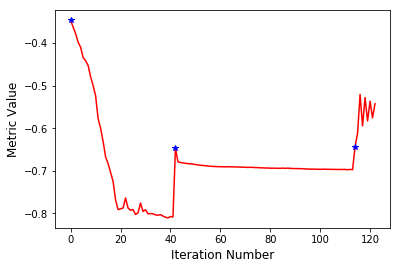


===== Registration Info =====
Final metric value: 	-0.5655408250240676
Last iteration: 	9
Stop condition: 
GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.



In [11]:
final_transform = registration_mi(fixed_image, moving_image, initial_transform,
                               bins = 50, num_iterations = 100)

Form the plot we can observe how the multiresolution framework works. The registration algorithm goes from images scale down 4 times, then 2 and finally at full resolution.

Always remember to see why the optimizer terminated. This will help you understand whether termination is too early, either due to thresholds being too tight, early termination due to small number of iterations - numberOfIterations, or too loose, early termination due to large value for minimal change in similarity measure - convergenceMinimumValue)    

The computed transform is:

In [14]:
print(transform_info(initial_transform))


===== Transform Info =====
Transform type: 	Euler3DTransform
Dimensions: 		3
Parameters: 		(0.021248824107106472, -0.005986501697035448, -0.08073511199774476, 21.033862419096508, -34.196077569876664, -23.926569742540234)



## Visualize the Registration in 2D

The result in visualized in here.

In [12]:
# Resample the moving image to the fixed image space
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, 
                                 sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# Visualize the image in the fixed image space
interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), 
         alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=14, description='image_z', max=29), FloatSlider(value=0.5, description='…

## Visualize Registration in 3D

The registration process can be visualized in a single image in 3D. We use the same principle as the axial image with alpha.

Here, a function to visualize the registration is defined.

In [30]:
def display_volumes_with_alpha(alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,:] + alpha*moving[:,:,:]
    imshow_3d(img, controls = True)

Now, the visualization function is used.

In [31]:
# Resample the moving image to the fixed image space
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, 
                                 sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# Visualize the image in the fixed image space
interact(display_volumes_with_alpha, image_z=(0,fixed_image.GetSize()[2]), 
         alpha=(0.0,1.0,0.1), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

## Write the Results

If we are satisfied with the results, we can store the solution in files.

In [29]:
prefix = './images/'
# prefix = '/content/registration_tutorial/images/'

sitk.WriteImage(moving_resampled, prefix + 'training_001_mr_T1_registered.mha')
sitk.WriteTransform(final_transform, prefix + 'RIRE_training_001_CT_2_mr_T1.tfm')